<a href="https://colab.research.google.com/github/Yug-Oswal/Custom-DistributedTraining-TF/blob/main/ObjectLocalization(FromScratch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np

AUTO = tf.data.AUTOTUNE

In [35]:
print("Tensorflow Version: ", tf.__version__)

Tensorflow Version:  2.15.0


In [36]:
train_data, train_info = tfds.load("mnist", split="train", as_supervised=True, with_info=True)
valid_data = tfds.load("mnist", split="test", as_supervised=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [37]:
ds = train_data.take(10)
tfds.as_dataframe(ds, train_info)

,image,label
0,,4
1,,1
2,,0
3,,7
4,,8
5,,1
6,,2
7,,7
8,,1
9,,6


In [38]:
def transform_image(image, label):
  x_min = tf.random.uniform((), 0, 48, dtype=tf.int64)
  y_min = tf.random.uniform((), 0, 48, dtype=tf.int64)
  image = tf.image.pad_to_bounding_box(image, y_min, x_min, 75, 75)
  image = tf.cast(image, dtype=tf.float32)
  x_min = tf.cast(x_min, dtype=tf.float32)
  y_min = tf.cast(y_min, dtype=tf.float32)
  image /= 255.
  x_max = (x_min + 28) / 75
  y_max = (y_min + 28) / 75
  x_min /= 75
  y_min /= 75

  return image, (tf.one_hot(label, 10), [x_min, y_min, x_max, y_max])

In [39]:
BATCH_SIZE = 32

In [40]:
def transform_train_test_data(train_data, test_data):
  train_data = train_data.map(transform_image, num_parallel_calls=AUTO)
  train_data = train_data.shuffle(10000, reshuffle_each_iteration=True)
  train_data = train_data.repeat()
  train_data = train_data.batch(batch_size=BATCH_SIZE, drop_remainder=True)
  train_dataset = train_data.prefetch(-1)

  test_data = test_data.map(transform_image, num_parallel_calls=AUTO)
  test_data = test_data.repeat()
  test_dataset = test_data.batch(batch_size=BATCH_SIZE, drop_remainder=True).prefetch(-1)

  return train_dataset, test_dataset

In [41]:
training_dataset, validation_dataset = transform_train_test_data(train_data, valid_data)

In [42]:
def display_images(dataset, num):
  count = 0
  ds = dataset.take(1)
  fig, axs = plt.subplots(1, num)
  for batch in ds:
    digits = batch[0].numpy()
    labels = batch[1][0].numpy()
    bboxes = batch[1][1].numpy()
    for digit, label, bbox in zip(digits, labels, bboxes):
      if count >= num:
        break
      image, xlabel = draw_bounding_boxes(digit, label, bbox)
      axs[count].imshow(image)
      axs[count].set_xlabel(xlabel)
      axs[count].set_xticks([])
      axs[count].set_yticks([])
      count += 1
    plt.show()

def draw_bounding_boxes(digit, label, bbox):
  xmin = bbox[0]
  ymin = bbox[1]
  xmax = bbox[2]
  ymax = bbox[3]
  image_array = digit * 255.
  image_array = image_array.reshape((75, 75))
  image = Image.fromarray(image_array)
  im_width, im_height = image.size
  draw = ImageDraw.Draw(image)

  (left, top, right, bottom) = (xmin * im_width,
                                ymin * im_height,
                                xmax * im_width,
                                ymax * im_height)
  draw.line([(left, bottom), (right, bottom), (right, top), (left, top), (left, bottom)],
            fill="white")
  return image, np.argmax(label)

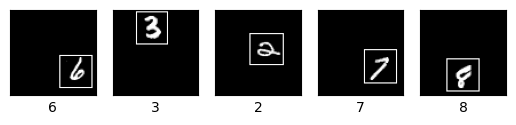

In [43]:
display_images(training_dataset, 5)

In [50]:
# class ObjectLocalizationModel(tf.keras.Model):
#   def __init__(self, input_shape=(75, 75, 1), filters=64, kernel=3, units=128, num_classes=10):
#     super(ObjectLocalizationModel, self).__init__()
#     self.conv1 = tf.keras.layers.Conv2D(16, kernel, input_shape=input_shape, activation='relu')
#     self.max_pool = tf.keras.layers.MaxPooling2D((2, 2))
#     self.conv2 = tf.keras.layers.Conv2D((filters-32), kernel, activation='relu')
#     self.conv3 = tf.keras.layers.Conv2D(filters, kernel, activation='relu')
#     self.flatten = tf.keras.layers.Flatten()
#     self.hidden = tf.keras.layers.Dense(units=units, activation='relu')
#     self.classification_out = tf.keras.layers.Dense(units=num_classes, activation='softmax', name="classification")
#     self.box_out = tf.keras.layers.Dense(units=4, activation='relu', name="bounding_box")

#   def call(self, inputs):
#     x = self.conv1(inputs)
#     x = self.max_pool(x)
#     x = self.conv2(x)
#     x = self.max_pool(x)
#     x = self.conv3(x)
#     x = self.max_pool(x)
#     x = self.flatten(x)
#     x = self.hidden(x)
#     classes = self.classification_out(x)
#     bbox = self.box_out(x)
#     return {"classification": classes, "bounding_box": bbox}

In [63]:
def ObjectLocalizationModel():
  inputs = tf.keras.layers.Input(shape=(75, 75, 1))
  x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(inputs)
  x = tf.keras.layers.MaxPooling2D((2, 2))(x)
  x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
  x = tf.keras.layers.MaxPooling2D((2, 2))(x)
  x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
  x = tf.keras.layers.MaxPooling2D((2, 2))(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(units=128, activation='relu')(x)
  classes = tf.keras.layers.Dense(units=10, activation='softmax', name="classification")(x)
  bbox = tf.keras.layers.Dense(units=4, activation='relu', name="bounding_box")(x)

  model = tf.keras.Model(inputs=inputs, outputs=[classes, bbox])
  return model

In [64]:
model = ObjectLocalizationModel()
model.compile(
    optimizer="adam",
    loss={
        "classification": "categorical_crossentropy",
        "bounding_box": "mse"
    },
    metrics={
        "classification": "accuracy",
        "bounding_box": "mse"
    }
)

In [65]:
# model.predict(tf.constant([1], shape=[1, 75, 75, 1], dtype=tf.float32))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 75, 75, 1)]          0         []                            
                                                                                                  
 conv2d_27 (Conv2D)          (None, 73, 73, 16)           160       ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_12 (MaxPooli  (None, 36, 36, 16)           0         ['conv2d_27[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_28 (Conv2D)          (None, 34, 34, 32)           4640      ['max_pooling2d_12[0][0]

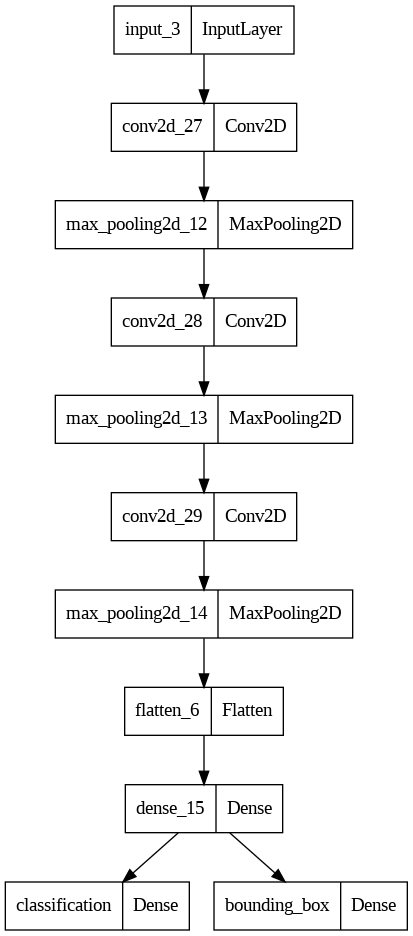

In [67]:
# Sometimes, having high modularization is not that good :) chore: Need to figure out how to
# viz the model entirely rather than as a object localization model module
# chore completed but not entirely solved, plot_model with class of custom model not done
tf.keras.utils.plot_model(model)

In [68]:
EPOCHS=20
steps_per_epoch = 60000 // BATCH_SIZE
validation_steps = 10000 // BATCH_SIZE
model.fit(training_dataset,
          validation_data=validation_dataset,
          epochs=EPOCHS,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps)

Epoch 1/20
1875/1875 [==============================] - 316s 167ms/step - loss: 0.6139 - classification_loss: 0.5978 - bounding_box_loss: 0.0160 - classification_accuracy: 0.7952 - bounding_box_mse: 0.0160 - val_loss: 0.1837 - val_classification_loss: 0.1767 - val_bounding_box_loss: 0.0070 - val_classification_accuracy: 0.9430 - val_bounding_box_mse: 0.0070
Epoch 2/20
1875/1875 [==============================] - 316s 168ms/step - loss: 0.1673 - classification_loss: 0.1625 - bounding_box_loss: 0.0048 - classification_accuracy: 0.9493 - bounding_box_mse: 0.0048 - val_loss: 0.1416 - val_classification_loss: 0.1381 - val_bounding_box_loss: 0.0036 - val_classification_accuracy: 0.9534 - val_bounding_box_mse: 0.0036
Epoch 3/20
1875/1875 [==============================] - 299s 159ms/step - loss: 0.1184 - classification_loss: 0.1161 - bounding_box_loss: 0.0023 - classification_accuracy: 0.9640 - bounding_box_mse: 0.0023 - val_loss: 0.1008 - val_classification_loss: 0.0990 - val_bounding_box_lo

In [69]:
def intersection_over_union(true_box, pred_box):
  x_min_true, y_min_true, x_max_true, y_max_true = np.split(true_box, 4, axis=1)
  x_min_pred, y_min_pred, x_max_pred, y_max_pred = np.split(pred_box, 4, axis=1)

  x_min_overlap = np.maximum(x_min_true, x_min_pred)
  y_min_overlap = np.minimum(y_min_true, y_min_pred)
  x_max_overlap = np.minimum(x_max_true, x_max_pred)
  y_max_overlap = np.maximum(y_max_true, y_max_pred)

  intersection_area = (np.maximum((x_max_overlap - x_min_overlap), 0) * np.maximum((y_max_overlap - y_min_overlap), 0))
  true_box_area = (x_max_true - x_min_true) * (y_max_true - y_min_true)
  pred_box_area = (x_max_pred - x_min_pred) * (y_max_pred - y_min_pred)
  union_area = true_box_area + pred_box_area - intersection_area

  smoothing_factor = 1e-10
  iou = (intersection_area + smoothing_factor) / (union_area + smoothing_factor)